In [1]:
import warnings
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import pandas_profiling

warnings.simplefilter("ignore", FutureWarning)

%matplotlib inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
data = pd.read_csv("Data/WaffleDivorce.csv", sep=';')
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


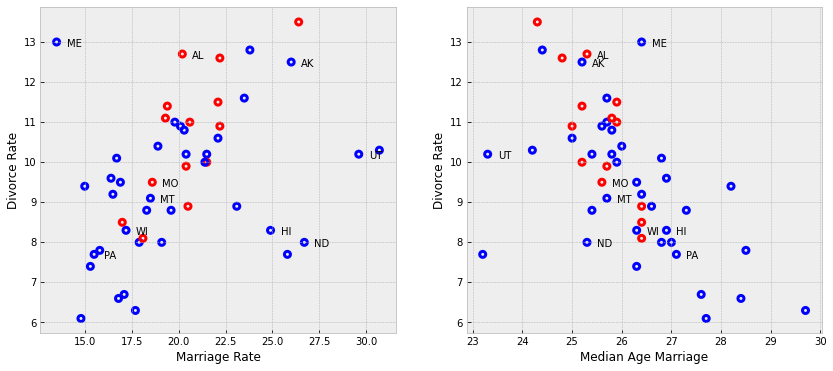

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

colors = ['blue', 'red']
selection = data.sample(n=10)

ax1.scatter(data.Marriage, data.Divorce, color=(0,0,0,0), edgecolor=data.South.apply(lambda d: colors[d]), lw=3)
ax1.set_xlabel("Marriage Rate")
ax1.set_ylabel("Divorce Rate")
ax2.scatter(data.MedianAgeMarriage, data.Divorce, color=(0,0,0,0), edgecolor=data.South.apply(lambda d: colors[d]), lw=3)
ax2.set_xlabel("Median Age Marriage")
ax2.set_ylabel("Divorce Rate")

for idx, state in selection.iterrows():
    ax1.annotate(f"{state.Loc}", xy=(state.Marriage, state.Divorce), textcoords="offset points", xytext=(10, -5))
    ax2.annotate(f"{state.Loc}", xy=(state.MedianAgeMarriage, state.Divorce), textcoords="offset points", xytext=(10, -5))

<AxesSubplot:xlabel='MedianAgeMarriage', ylabel='Divorce'>

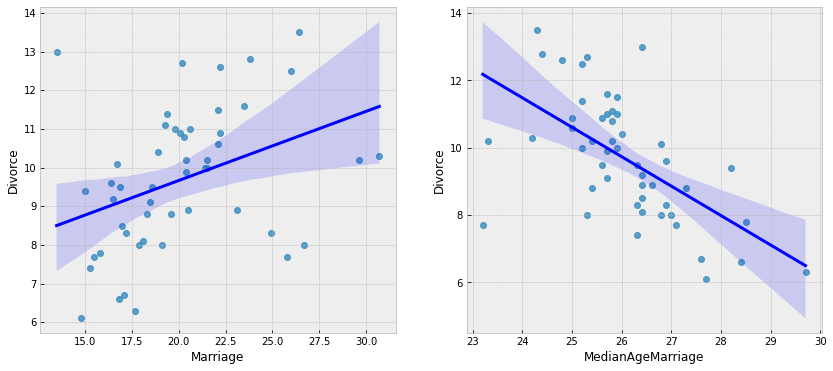

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot('Marriage', 'Divorce', data=data, ax=ax1, line_kws={'color': 'blue'})
sns.regplot('MedianAgeMarriage', 'Divorce', data=data, ax=ax2, line_kws={'color': 'blue'})

In [5]:
def scale(serie): 
    serie_std = (serie - serie.mean()) / serie.std()
    return serie_std
MedianAgeMarriageStd = scale(data.MedianAgeMarriage)
MarriageStd = scale(data.Marriage)
DivorceStd = scale(data.Divorce)

In [6]:
with pm.Model() as m51:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)
    mu = a + bA*MedianAgeMarriageStd.values + bM*MarriageStd.values
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("DivorceRate", mu, sigma, observed=DivorceStd.values)
    idata51 = pm.sample()
    
az.summary(idata51)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.100,-0.196,0.175,0.002,0.001,3270.0,3067.0,1.0
bA,-0.609,0.161,-0.897,-0.296,0.004,0.003,2024.0,2348.0,1.0
bM,-0.061,0.163,-0.377,0.237,0.004,0.003,1928.0,2211.0,1.0
sigma,0.829,0.087,0.672,0.994,0.002,0.001,3431.0,2706.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

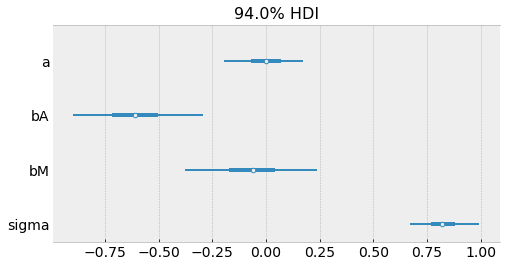

In [7]:
az.plot_forest(idata51, combined=True, figsize=(8,4))

In [8]:
# X and Y are not independent from each other.
N = 1000
Z = np.random.binomial(1, 0.5, N)
X = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
Y = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
print(pd.crosstab(X, Y, rownames=["X"], colnames=["Y"]))
print(stats.pearsonr(X, Y))


# Conditioning on Z, then X and Y are independent from each other.
print(pd.crosstab(X[Z==0], Y[Z==0], rownames=["X[Z==0]"], colnames=["Y[Z==0]"]))
print(stats.pearsonr(X[Z==0], Y[Z==0]))
print(pd.crosstab(X[Z==1], Y[Z==1], rownames=["X[Z==1]"], colnames=["Y[Z==1]"]))
print(stats.pearsonr(X[Z==1], Y[Z==1]))

Y    0    1
X          
0  412   85
1   93  410
(0.6441037993881621, 2.8296941347807854e-118)
Y[Z==0]    0   1
X[Z==0]         
0        410  51
1         49   9
(0.04388997505839274, 0.31830230467633863)
Y[Z==1]   0    1
X[Z==1]         
0         2   34
1        44  401
(-0.03876186550036958, 0.3963149040687798)


Text(0.5, 1.0, 'The forker confound. Conditioning on Z, X and Y are independent')

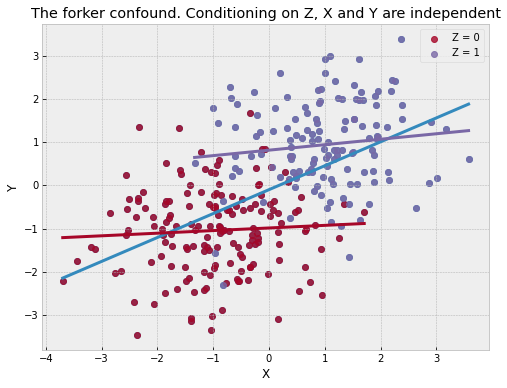

In [9]:
N = 300
Z = np.random.binomial(1, 0.5, N)
X = np.random.normal(2*Z - 1, 1, N)
Y = np.random.normal(2*Z - 1, 1, N)

colors = np.where(Z == 0, 'black', 'red')
fig, ax = plt.subplots()
sns.regplot(X, Y, scatter=True, ax=ax, ci=None)
sns.regplot(X[Z==0], Y[Z==0], ax=ax, label='Z = 0', ci=None)
sns.regplot(X[Z==1], Y[Z==1], ax=ax, label='Z = 1', ci=None)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
ax.set_title("The forker confound. Conditioning on Z, X and Y are independent")